In [ ]:
import jax
import numpy as np
import jax.numpy as jnp
import equinox as eqx
import optax

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.style as mplstyle

import seaborn as sns

from NeuralNetworkEvolution.config import MLPConfig
from NeuralNetworkEvolution.activations import sin
from NeuralNetworkEvolution.mlp import CustomMLP, mlp_plot

In [ ]:
plt.style.use('default')
sns.set_theme(context='paper', style='white', palette='viridis', font='serif',
            font_scale=2, color_codes=True, rc={'text.usetex' : True})
mplstyle.use('fast')

In [ ]:
def initialize_optimizer_state(mlp, optimizer):
    return optimizer.init(eqx.filter(mlp, eqx.is_inexact_array))

In [ ]:
input_size = 3
hidden_sizes = [2, 3] 
output_size = 1
initial_activation_list = [jax.nn.relu]

homo_config = MLPConfig(input_size=input_size,
                        output_size=output_size,
                        hidden_sizes=hidden_sizes,
                        initial_activation_list=initial_activation_list,
                        seed=42)

In [ ]:
mlp = CustomMLP(homo_config)

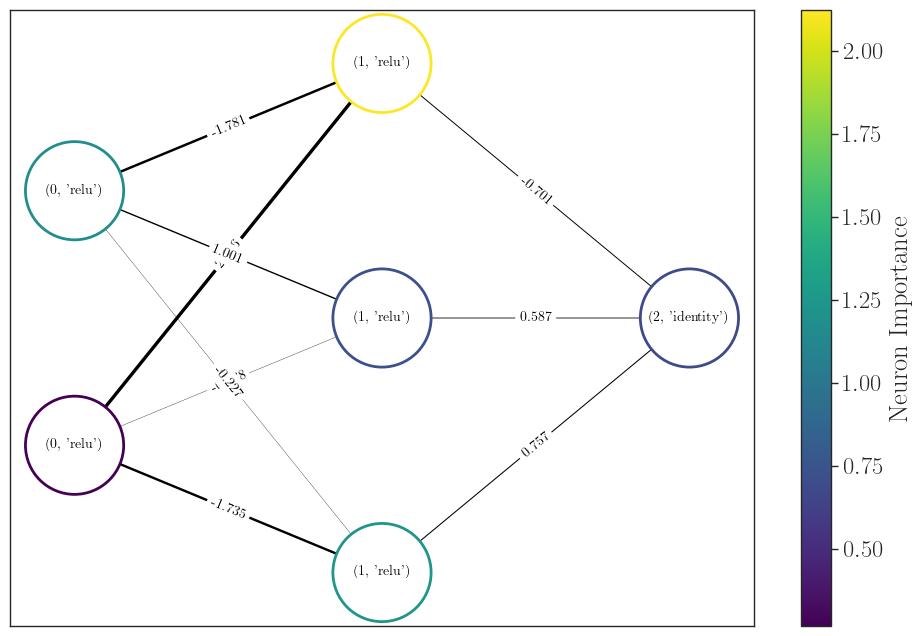

In [ ]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.show()

In [ ]:
@eqx.filter_value_and_grad()
def compute_loss(mlp, x, y):
    pred = mlp(x)
    return jnp.mean((pred - y) ** 2)

In [ ]:
@eqx.filter_jit()
def train_step(mlp, x, y, opt_state, opt_update):
    loss, grads = compute_loss(mlp, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    mlp = eqx.apply_updates(mlp, updates)
    return loss, mlp, opt_state

In [ ]:
x = jnp.array([1.0, 2.0, 3.0])
y = jnp.array([1.0])

In [ ]:
mlp = CustomMLP(homo_config)
opt = optax.sgd(learning_rate=1e-2)
opt_state = initialize_optimizer_state(mlp, opt)

In [ ]:
initial_adjacency_matrix = mlp.adjacency_matrix()

<matplotlib.image.AxesImage>

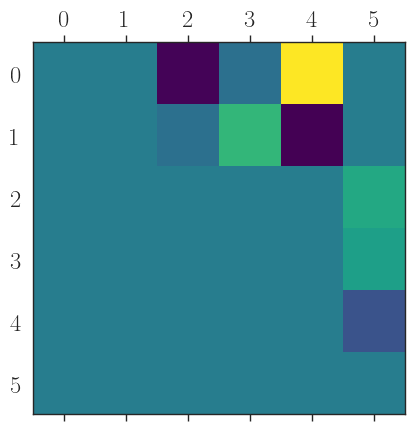

In [ ]:
plt.matshow(initial_adjacency_matrix, cmap=plt.cm.viridis)

In [ ]:
activation_list = [jax.nn.relu, sin, jax.nn.tanh]
num_epochs = 1000
add_node_every = 10
remove_node_every = 10
key = jax.random.PRNGKey(42)
Loss_history = []
Node_history = []
graph_history = []
Update_history = []
threshold = 1e-8

In [ ]:
for epoch in range(num_epochs):
    loss, mlp, opt_state = train_step(mlp, x, y, opt_state, opt.update)
    print(f"Epoch {epoch}, Prediction: {mlp(x)}, Loss: {loss}")

    key, add_key, sub_key = jax.random.split(key,3)
    n_neurons = sum(mlp.get_shape())
    Loss_history.append(loss)
    Node_history.append(n_neurons)


    # Dynamically add or remove neurons
    if (epoch + 1) % add_node_every == 0:
        if len(Update_history) == 0 or Update_history[-1][2] > loss or Update_history[-1][3] == "removed":
            # if no previous addition or last addition was rejected, add a neuron
            # if last addition was accepted, add a neuron
            add_key, act_key = jax.random.split(add_key)
            activation = activation_list[jax.random.choice(key, jnp.arange(len(activation_list)))]
            layer_idx = mlp.most_important_layer()
            mlp.add_neuron(layer_index=layer_idx, activation=activation, key=act_key)
            opt_state = initialize_optimizer_state(mlp, opt)

            Update_history.append((epoch, n_neurons, loss, activation.__name__, layer_idx))
            print(f"Added neuron to hidden layer {layer_idx+1} with activation {activation.__name__}")
            print(mlp.get_shape())
        
        elif Update_history[-1][2] < loss:
            # if last addition doesn't improve loss, remove the worst neuron

            layer_idx, neuron_idx = mlp.least_important_neuron()
            print(f"Removing neuron from hidden layer {layer_idx+1} at index {neuron_idx}")
            mlp.remove_neuron(layer_index=layer_idx, neuron_index=neuron_idx)
            opt_state = initialize_optimizer_state(mlp, opt)
            Update_history.append((epoch, n_neurons, loss, "removed", layer_idx))
            print(f"Rejecting last addition,\n Removed neuron from hidden layer {layer_idx+1} at index {neuron_idx}")
            print(mlp.get_shape())
        
    if loss < threshold:
        # if loss is below threshold, stop training
        print(f"Threshold reached, stopping training at epoch {epoch}")
        break
    


print("Final Prediction:", mlp(x))

Epoch 0, Prediction: 1.30978262424469, Loss: 5.648972034454346
Epoch 1, Prediction: 1.1386868953704834, Loss: 0.09596527367830276
Epoch 2, Prediction: 1.0649170875549316, Loss: 0.019234055653214455
Epoch 3, Prediction: 1.030922770500183, Loss: 0.004214228130877018
Epoch 4, Prediction: 1.0148439407348633, Loss: 0.0009562177583575249
Epoch 5, Prediction: 1.0071512460708618, Loss: 0.00022034258290659636
Epoch 6, Prediction: 1.0034509897232056, Loss: 5.114031955599785e-05
Epoch 7, Prediction: 1.0016666650772095, Loss: 1.1909330169146415e-05
Epoch 8, Prediction: 1.000805139541626, Loss: 2.7777725790656405e-06
Epoch 9, Prediction: 1.0003892183303833, Loss: 6.482496814896876e-07
Added neuron to hidden layer 2 with activation sin
[2, 4, 1]
Epoch 10, Prediction: 2.416797637939453, Loss: 0.7838659286499023
Epoch 11, Prediction: -0.1974349319934845, Loss: 2.0073156356811523
Epoch 12, Prediction: 1.9107873439788818, Loss: 1.4338502883911133
Epoch 13, Prediction: 1.2098621129989624, Loss: 0.8295335

In [ ]:
Update_history

[(9, 6, Array(6.482497e-07, dtype=float32), 'sin', Array(1, dtype=int32)),
 (19, 7, Array(0.06479075, dtype=float32), 'removed', Array(0, dtype=int32)),
 (29, 6, Array(0.01416366, dtype=float32), 'tanh', Array(1, dtype=int32)),
 (39, 7, Array(0.06056653, dtype=float32), 'removed', Array(1, dtype=int32)),
 (49, 6, Array(0.01549527, dtype=float32), 'sin', Array(1, dtype=int32))]

In [ ]:
final_adjacency_matrix = mlp.adjacency_matrix()

<matplotlib.image.AxesImage>

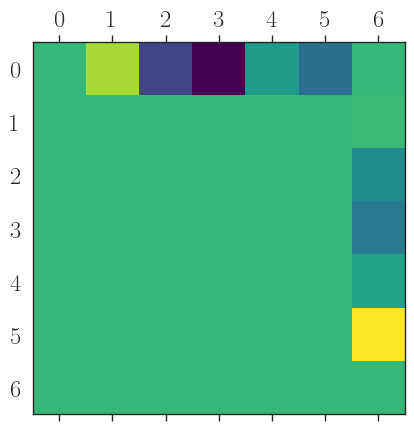

In [ ]:
plt.matshow(final_adjacency_matrix, cmap=plt.cm.viridis)

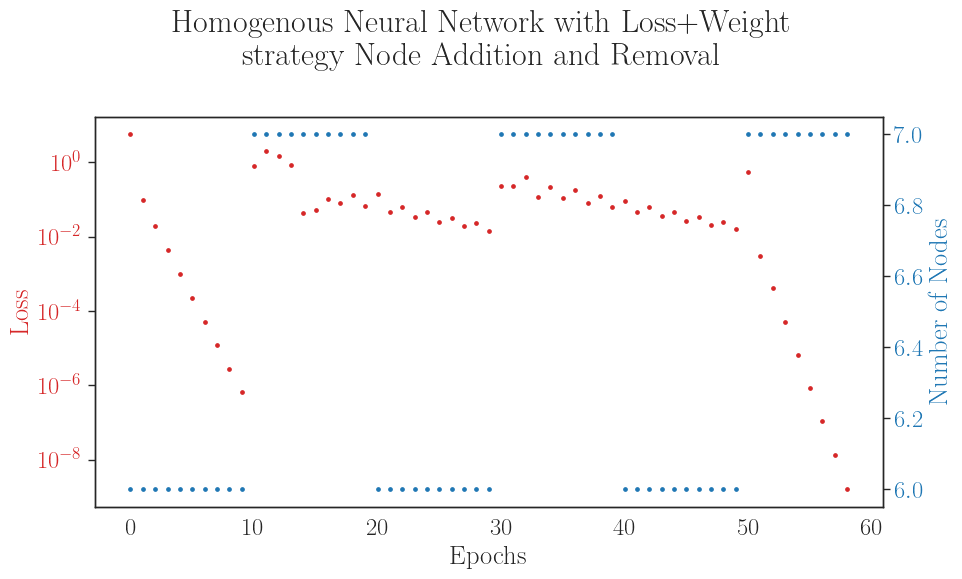

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(0,len(Loss_history)), Loss_history, ".", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0,len(Node_history)), Node_history, ".", color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.suptitle("Homogenous Neural Network with Loss+Weight\n strategy Node Addition and Removal")
fig.tight_layout()

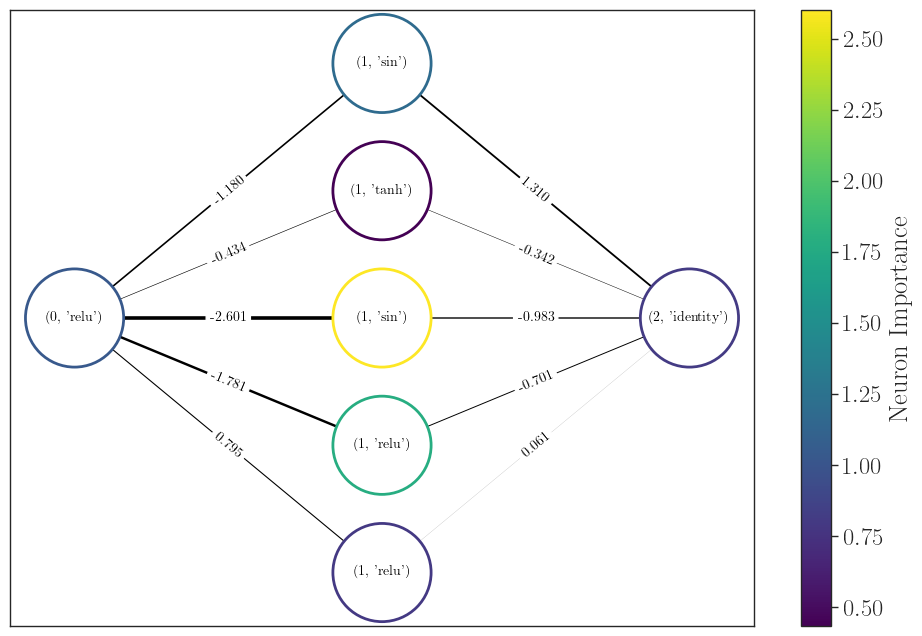

In [ ]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.show()